In [25]:
# load libraries
import torch
import torchvision
import numpy as np
import  matplotlib.pyplot  as plt
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms


In [26]:
data_folder="../AI_Based_PGD/data/"

data_transformer=transforms.Compose([transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),transforms.GaussianBlur(kernel_size=3),transforms.ElasticTransform(),
                                     transforms.Resize((224,224)),transforms.ToTensor()])
ds=ImageFolder(root=data_folder,transform=data_transformer)

In [27]:
from sklearn.model_selection import train_test_split
train_ds,test_ds=train_test_split(ds,test_size=0.2)
print(len(train_ds),len(test_ds))

115 29


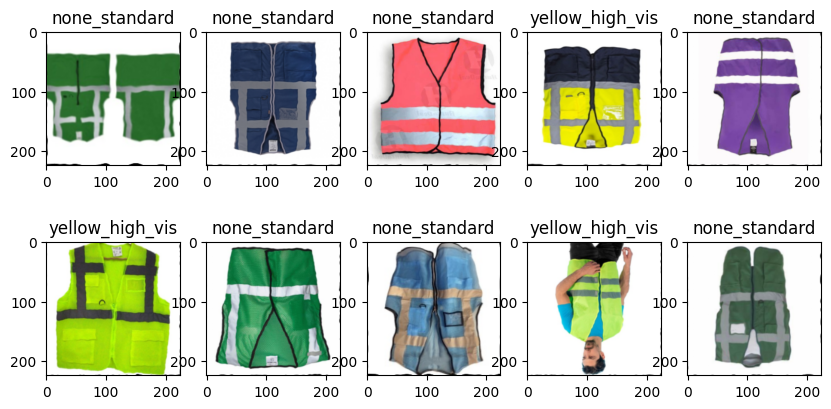

In [28]:
#Visualize random samples from training dataset
random_sample=np.random.choice(range(len(train_ds)),10)
plt.figure(figsize=(10,5))
for i,idx in enumerate(random_sample):
    plt.subplot(2,5,i+1)
    plt.imshow(torch.permute(train_ds[idx][0],(1,2,0)))
    plt.title(ds.classes[train_ds[idx][1]])

In [29]:
train_dataloader=DataLoader(train_ds,batch_size=8,shuffle=True)
test_dataloader=DataLoader(test_ds,batch_size=8,shuffle=False)


In [30]:
class high_vis_cloth_detector_model(nn.Module):
    def __init__(self, len_classes:int) -> None:
        super().__init__()
        self.feature_extractor1=nn.Sequential(nn.Conv2d(3,10,kernel_size=3,stride=1,padding=0),
                                             nn.ReLU())
        self.feature_extractor2=nn.Sequential(nn.Conv2d(10,10,kernel_size=3,stride=1,padding=0),nn.ReLU(),
                                               nn.MaxPool2d(kernel_size=3,stride=1,padding=0))
        self.feature_extractor3=nn.Sequential(nn.Conv2d(10,10,kernel_size=3,stride=1,padding=0),
                                             nn.ReLU())
        self.feature_extractor4=nn.Sequential(nn.Conv2d(10,10,kernel_size=3,stride=1,padding=0),nn.ReLU(),
                                               nn.MaxPool2d(kernel_size=3,stride=1,padding=0))
        self.classifier=nn.Sequential(nn.Flatten(),nn.Linear(in_features=449440,out_features=len_classes))
    def forward(self,x):
        x1=self.feature_extractor1(x)
        #print(x1.shape)
        x2=self.feature_extractor2(x1)
        #print(x2.shape)
        x3=self.feature_extractor3(x2)
        #print(x3.shape)
        x4=self.feature_extractor4(x3)
        #print(x4.shape)
        x5=self.classifier(x4)
        #print(x5.shape)
        return x5
model=high_vis_cloth_detector_model(len(ds.classes))
        



In [31]:
#Testing the model without training. making sure everything is fine...
model(next(iter(train_dataloader))[0])

tensor([[ 0.0241, -0.0572,  0.0312,  0.0071],
        [ 0.0216, -0.0611,  0.0296,  0.0075],
        [ 0.0249, -0.0591,  0.0259,  0.0081],
        [ 0.0239, -0.0598,  0.0247,  0.0103],
        [ 0.0241, -0.0584,  0.0264,  0.0095],
        [ 0.0213, -0.0592,  0.0278,  0.0085],
        [ 0.0225, -0.0571,  0.0289,  0.0076],
        [ 0.0224, -0.0604,  0.0222,  0.0063]], grad_fn=<AddmmBackward0>)

In [32]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [33]:
num_epochs=200
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=1e-5)
train_loss=[]
test_loss=[]
train_acc=[]
test_acc=[]
#training loop
for epoch in range(num_epochs):
    model.train()
    loss_per_epoch_train=0.0
    loss_per_epoch_test=0.0
    accuracy_per_epoch_train=0.0
    accuracy_per_epoch_test=0.0
    for batch,(x,y) in enumerate(train_dataloader):
        y_pred_logits=model(x)
        #calculate loss
        loss=loss_fn(y_pred_logits,y)
        loss_per_epoch_train+=loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        accuracy_per_epoch_train += accuracy_fn(y_true=y, y_pred=y_pred_logits.argmax(dim=1))
        
    loss_per_epoch_train/=len(train_dataloader)
    accuracy_per_epoch_train/=len(train_dataloader)
    train_loss.append(loss_per_epoch_train)
    train_acc.append(accuracy_per_epoch_train)
    model.eval()
    with torch.inference_mode():
        for batch,(x_test,y_test) in enumerate(test_dataloader):
            y_pred_logits_test=model(x_test)
            loss_test=loss_fn(y_pred_logits_test,y_test)
            loss_per_epoch_test+=loss_test
            accuracy_per_epoch_test += accuracy_fn(y_true=y_test, y_pred=y_pred_logits_test.argmax(dim=1))
        loss_per_epoch_test/=len(test_dataloader)
        accuracy_per_epoch_test/=len(test_dataloader)
        test_loss.append(loss_per_epoch_test)
        test_acc.append(accuracy_per_epoch_test)
    if epoch%20==0:
        print(f"===============Epoch:{epoch}===============")
        print(f"Train Loss:{loss_per_epoch_train:.6f}")
        print(f"Train Accuracy:{accuracy_per_epoch_train:.2f}%")
        print(f"Test Loss:{loss_per_epoch_test:.6f}")
        print(f"Test Accuracy:{accuracy_per_epoch_test:.2f}%")

===============Epoch:0===============
Train Loss:1.371574
Train Accuracy:25.00%
Test Loss:1.604337
Test Accuracy:20.62%
===============Epoch:20===============
Train Loss:1.023787
Train Accuracy:52.22%
Test Loss:1.174917
Test Accuracy:42.50%
===============Epoch:40===============
Train Loss:0.785888
Train Accuracy:72.50%
Test Loss:0.939742
Test Accuracy:56.88%
===============Epoch:60===============
Train Loss:0.575176
Train Accuracy:83.33%
Test Loss:0.710289
Test Accuracy:61.88%
===============Epoch:80===============
Train Loss:0.449394
Train Accuracy:87.78%
Test Loss:0.565049
Test Accuracy:75.62%
===============Epoch:100===============
Train Loss:0.364537
Train Accuracy:84.17%
Test Loss:0.532326
Test Accuracy:69.38%
===============Epoch:120===============
Train Loss:0.259193
Train Accuracy:94.17%
Test Loss:0.425911
Test Accuracy:75.62%
===============Epoch:140===============
Train Loss:0.201453
Train Accuracy:95.83%
Test Loss:0.372987
Test Accuracy:83.75%
===============Epoch:160======

In [34]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "high_vis_cloth_detector_model1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\high_vis_cloth_detector_model1.pth


Text(0, 0.5, 'Loss')

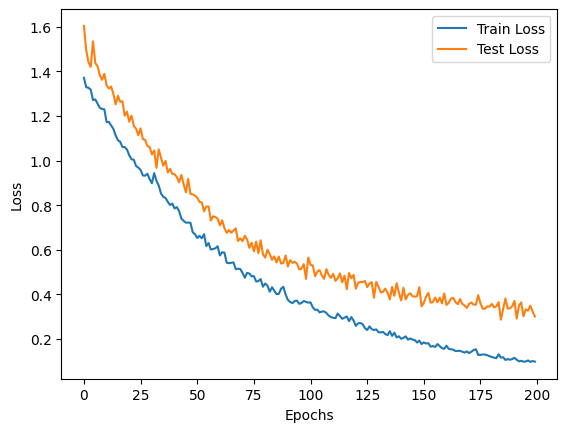

In [44]:
#train_loss=[x.detach().numpy() for x in train_loss]
#test_loss=[x.detach().numpy() for x in test_loss]
plt.plot(np.array(train_loss))
plt.plot(np.array(test_loss))
plt.legend(["Train Loss","Test Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy %')

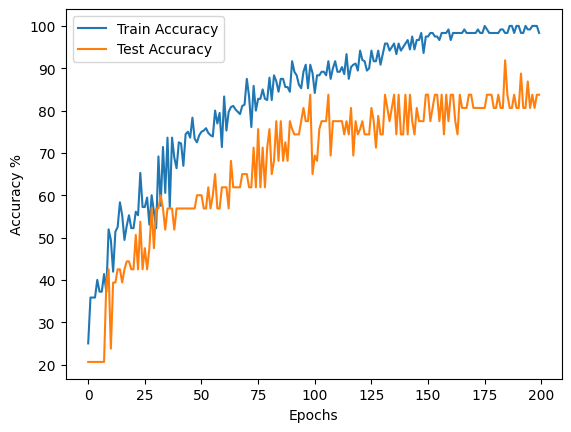

In [43]:
plt.plot(np.array(train_acc),)
plt.plot(np.array(test_acc))
plt.legend(["Train Accuracy","Test Accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")

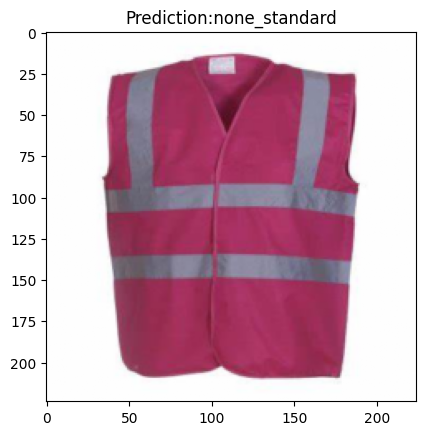

In [65]:
# Make Predictions and Plot
from PIL import Image
def predict(pic_path:str):
    image=Image.open(pic_path)
    image_transformer=transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
    image_tensor=image_transformer(image)
    #print(image_tensor.unsqueeze(dim=0).shape)
    pred=model(image_tensor.unsqueeze(dim=0))
    label_id=torch.argmax(pred)
    label=ds.classes[torch.argmax(pred)]
    plt.imshow(torch.permute(image_tensor,(1,2,0)))
    plt.title(f"Prediction:{label}")
    return label_id,label
label_id,label=predict("test\\OIP (23).jpg")
